# Imminent ICU Admission Classifier Cross Learning

## Imports & Inits

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import pickle
import scipy

import pandas as pd
import numpy as np
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

from pathlib import Path

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from scikitplot.metrics import *

from utils.data_utils import set_group_splits
from utils.metrics import BinaryAvgMetrics, get_best_model
from utils.plots import *

In [3]:
from args import args
vars(args)

{'path': PosixPath('../data'),
 'workdir': PosixPath('../data/workdir'),
 'model': 'rf',
 'figdir': PosixPath('../data/workdir/figdir'),
 'vectordir': PosixPath('../data/workdir/vectordir'),
 'modeldir': PosixPath('../data/workdir/rf/models'),
 'mimic_notes': PosixPath('../mimic_data/notes_all_proc.csv'),
 'mlh_notes': PosixPath('../mlh_data/notes_all_proc.csv'),
 'mimic_src_thresh': 0.133,
 'mlh_src_thresh': 0.38}

In [3]:
mimic_notes_df = pd.read_csv(args.mimic_notes, usecols=['hadm_id', 'note', 'imi_adm_label'])
mimic_notes_df = mimic_notes_df[mimic_notes_df['imi_adm_label'] != -1].reset_index(drop=True)

mlh_notes_df = pd.read_csv(args.mlh_notes, usecols=['hadm_id', 'note', 'imi_adm_label'])
mlh_notes_df = mlh_notes_df[mlh_notes_df['imi_adm_label'] != -1].reset_index(drop=True)

mimic_notes_df.shape, mlh_notes_df.shape

((38112, 3), (116400, 3))

In [4]:
seed = 643
save = False

## MIMIC -> MLH

### MIMIC LR Development

In [5]:
with open(args.vectordir/f'mimic2mlh.pkl', 'rb') as f:
  mimic2mlh_vec = pickle.load(f)
  x_train_mimic = pickle.load(f)
  x_test_mlh = pickle.load(f)
  y_train_mimic = pickle.load(f)
  y_test_mlh = pickle.load(f)
  
x_train_mimic.shape, y_train_mimic.shape, x_test_mlh.shape, y_test_mlh.shape

((38112, 60000), (38112,), (116400, 60000), (116400,))

In [6]:
clf = RandomForestClassifier(n_estimators=400, min_samples_leaf=3, oob_score=True, class_weight='balanced', n_jobs=-1)
clf.fit(x_train_mimic, y_train_mimic)
pickle.dump(clf, open(args.modeldir/'mimic_full.pkl', 'wb'))

### Cross Testing

In [7]:
prob = clf.predict_proba(x_test_mlh)
pos_prob = prob[:, 1]

labels = ['Delayed', 'Imminent']
label_test = [labels[i] for i in y_test_mlh]

Text(0, 0.5, 'Sensitivity')

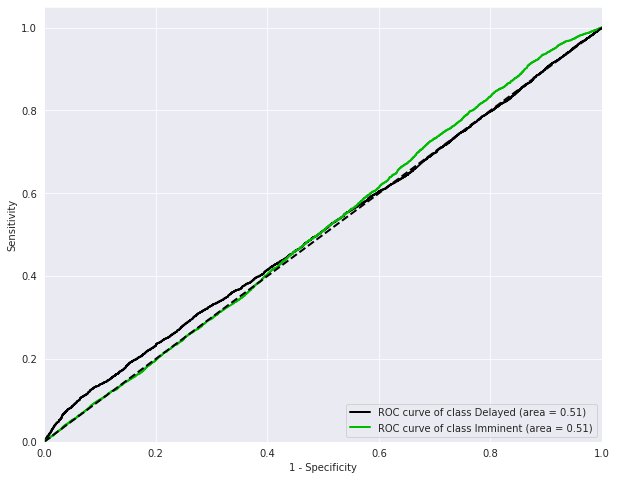

In [8]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc(label_test, prob, title='', ax=ax, plot_micro=False, plot_macro=False)
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')

(0.19, None)


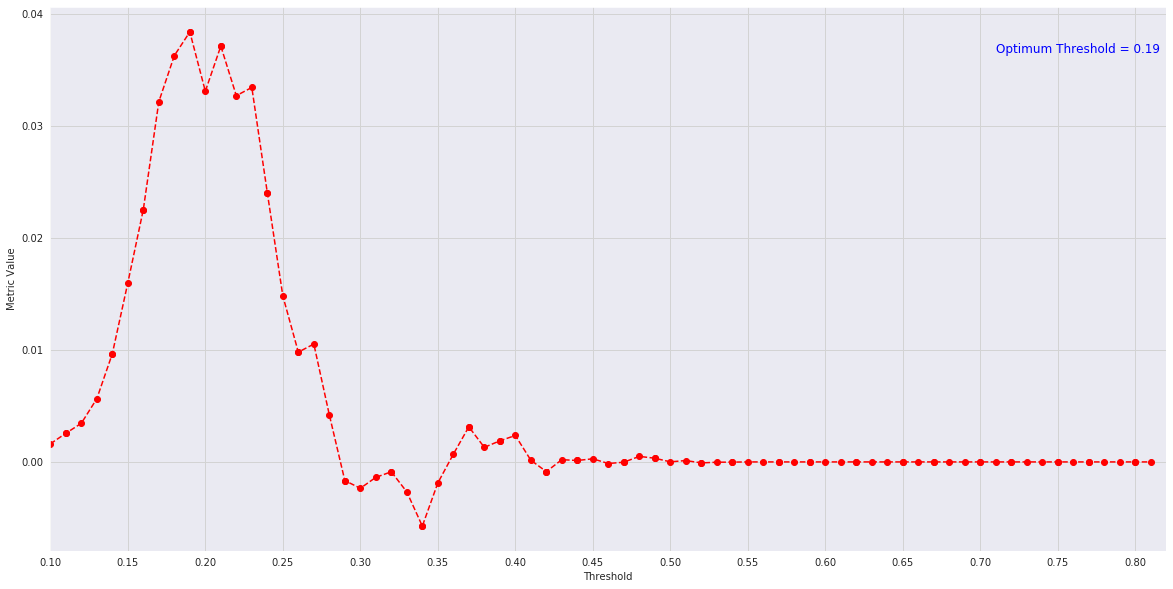

In [16]:
fig, ax = plt.subplots(figsize=(20, 10))
best_threshold = plot_thresh_metric(ax, y_test_mlh, pos_prob, lower=0.1, upper=0.81, n_vals=100, show_f1=False)
ax.text(0.71, ax.get_ylim()[1] * 0.9, f'Optimum Threshold = {best_threshold[0]}', fontsize=12, color='b')
print(best_threshold)

if save:
  fig.savefig(args.figdir/f'{args.model}_threshold_guide.pdf', dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_thresh_range(ax, y_test_mlh, pos_prob, lower=0.1, upper=0.81, n_vals=100)

if save:
  fig.savefig(args.figdir/f'{args.model}_metrics_vary.pdf', dpi=300)

In [17]:
threshold = 0.19
pred = (pos_prob > threshold).astype(np.int64)
cm = confusion_matrix(y_test_mlh, pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test_mlh, pos_prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'threshold': threshold,
}
metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.922
specificity,0.116
ppv,0.035
npv,0.977
f1,0.068
auroc,0.513
threshold,0.190


In [ ]:
fig, ax = plt.subplots(figsize=(11, 8))
plot_confusion_matrix(label_test, [labels[i] for i in pred], x_tick_rotation=45, ax=ax, normalize=True)

### Cross Training

In [18]:
mlh_cross_df = set_group_splits(mlh_notes_df.copy(), group_col='hadm_id', seed=seed, pct=0.9)

train_df = mlh_cross_df[mlh_cross_df['split'] == 'train'][['note', 'imi_adm_label']]
test_df = mlh_cross_df[mlh_cross_df['split'] == 'test'][['note', 'imi_adm_label']]

In [19]:
# x_train_cross_mlh = mimic2mlh_vec.transform(train_df['note'])
# x_test_cross_mlh = mimic2mlh_vec.transform(test_df['note'])

# with open(args.vectordir/f'mimic2mlh_643.pkl', 'wb') as f:
#   pickle.dump(x_train_cross_mlh, f)
#   pickle.dump(x_test_cross_mlh, f)

with open(args.vectordir/f'mimic2mlh_643.pkl', 'rb') as f:
  x_train_cross_mlh = pickle.load(f)
  x_test_cross_mlh = pickle.load(f)

y_train_cross_mlh, y_test_cross_mlh = train_df['imi_adm_label'], test_df['imi_adm_label']
x_train_cross_mlh.shape, y_train_cross_mlh.shape, x_test_cross_mlh.shape, y_test_cross_mlh.shape

((11043, 60000), (11043,), (105357, 60000), (105357,))

In [20]:
clf = RandomForestClassifier(n_estimators=400, min_samples_leaf=3, oob_score=True, class_weight='balanced', n_jobs=-1)
clf.fit(x_train_cross_mlh, y_train_cross_mlh)

prob = clf.predict_proba(x_test_cross_mlh)
pos_prob = prob[:, 1]

labels = ['Delayed', 'Imminent']
label_test = [labels[i] for i in y_test_cross_mlh]

Text(0, 0.5, 'Sensitivity')

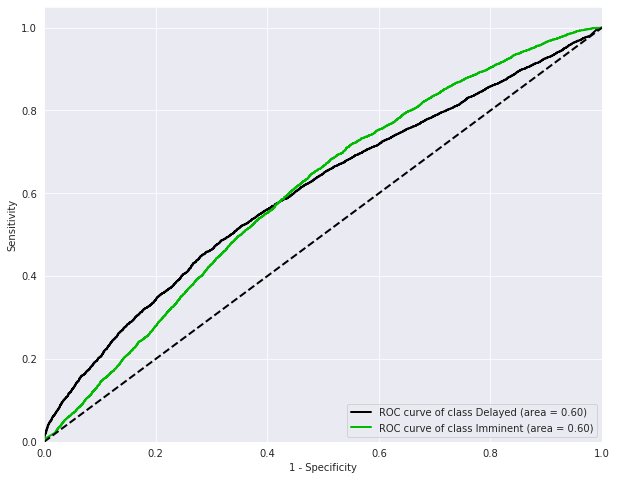

In [21]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc(label_test, prob, title='', ax=ax, plot_micro=False, plot_macro=False)
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')

In [33]:
threshold = 0.133
pred = (pos_prob > threshold).astype(np.int64)
cm = confusion_matrix(y_test_cross_mlh, pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test_cross_mlh, pos_prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'threshold': threshold,
}
metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.612
specificity,0.551
ppv,0.044
npv,0.977
f1,0.083
auroc,0.604
threshold,0.133


### Metrics

In [4]:
with open(args.workdir/args.model/f'mimic_mlh_preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  probs = pickle.load(f)
  preds = pickle.load(f)

bam = BinaryAvgMetrics(targs, preds, [prob[:, 1] for prob in probs])
bam.get_avg_metrics(defn=True)

,Value,Definition
sensitivity,0.504,"When it's ACTUALLY YES, how often does it PREDICT YES?"
specificity,0.636,"When it's ACTUALLY NO, how often does it PREDICT NO?"
ppv,0.046,"When it PREDICTS YES, how often is it correct?"
auroc,0.606,Indicates how well the model is capable of distinguishing between classes
npv,0.974,"When it PREDICTS NO, how often is it correct?"
f1,0.084,Harmonic mean of sensitivity and ppv


In [5]:
bam.get_avg_metrics(conf=0.95)

,Mean,Lower,Upper
sensitivity,0.504,0.500,0.509
specificity,0.636,0.574,0.698
ppv,0.046,0.036,0.056
auroc,0.606,0.555,0.657
npv,0.974,0.973,0.974
f1,0.084,0.068,0.101


## MLH -> MIMIC

### MIMIC LR Development

In [53]:
with open(args.vectordir/f'mlh2mimic.pkl', 'rb') as f:
  mlh2mimic_vec = pickle.load(f)
  x_train_mlh = pickle.load(f)
  x_test_mimic = pickle.load(f)
  y_train_mlh = pickle.load(f)
  y_test_mimic = pickle.load(f)
  
x_train_mlh.shape, y_train_mlh.shape, x_test_mimic.shape, y_test_mimic.shape

((116400, 60000), (116400,), (38112, 60000), (38112,))

In [54]:
clf = RandomForestClassifier(n_estimators=400, min_samples_leaf=3, oob_score=True, class_weight='balanced', n_jobs=-1)
clf.fit(x_train_mlh, y_train_mlh)
pickle.dump(clf, open(args.modeldir/'mlh_full.pkl', 'wb'))

### Cross Testing

In [55]:
prob = clf.predict_proba(x_test_mimic)
pos_prob = prob[:, 1]

labels = ['Delayed', 'Imminent']
label_test = [labels[i] for i in y_test_mimic]

Text(0, 0.5, 'Sensitivity')

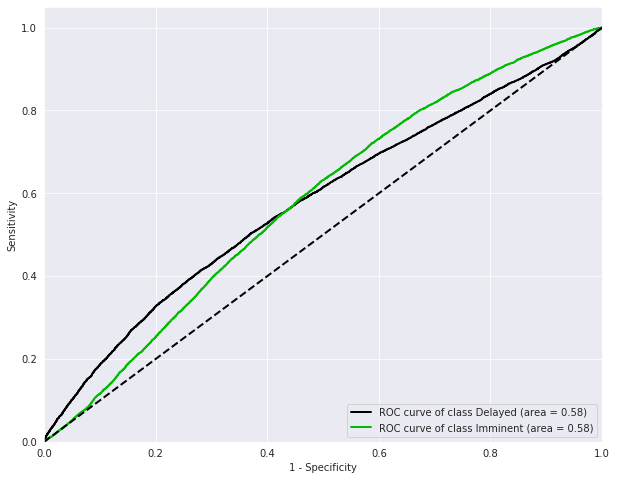

In [56]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc(label_test, prob, title='', ax=ax, plot_micro=False, plot_macro=False)
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')

../../utils/plots.py:206: RuntimeWarning: invalid value encountered in true_divide
  ppv = cms[:, 1, 1] / (cms[:, 1, 1] + cms[:, 0, 1])


(0.14, None)


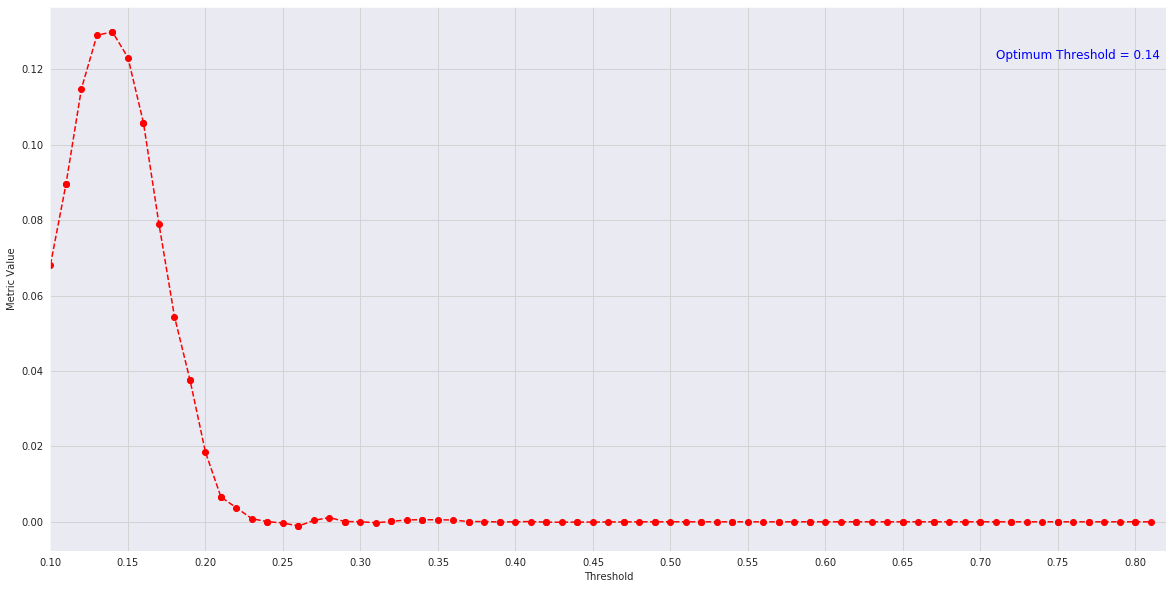

In [57]:
fig, ax = plt.subplots(figsize=(20, 10))
best_threshold = plot_thresh_metric(ax, y_test_mimic, pos_prob, lower=0.1, upper=0.81, n_vals=100, show_f1=False)
ax.text(0.71, ax.get_ylim()[1] * 0.9, f'Optimum Threshold = {best_threshold[0]}', fontsize=12, color='b')
print(best_threshold)

if save:
  fig.savefig(args.figdir/f'{args.model}_threshold_guide.pdf', dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_thresh_range(ax, y_test_mimic, pos_prob, lower=0.1, upper=0.81, n_vals=100)

if save:
  fig.savefig(args.figdir/f'{args.model}_metrics_vary.pdf', dpi=300)

In [62]:
threshold = 0.14
pred = (pos_prob > threshold).astype(np.int64)
cm = confusion_matrix(y_test_mimic, pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test_mimic, pos_prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'threshold': threshold,
}
metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.665
specificity,0.465
ppv,0.290
npv,0.809
f1,0.404
auroc,0.581
threshold,0.140


In [ ]:
fig, ax = plt.subplots(figsize=(11, 8))
plot_confusion_matrix(label_test, [labels[i] for i in pred], x_tick_rotation=45, ax=ax, normalize=True)

### Cross Training

In [41]:
mimic_cross_df = set_group_splits(mimic_notes_df.copy(), group_col='hadm_id', seed=seed, pct=0.9)

train_df = mimic_cross_df[mimic_cross_df['split'] == 'train'][['note', 'imi_adm_label']]
test_df = mimic_cross_df[mimic_cross_df['split'] == 'test'][['note', 'imi_adm_label']]

In [43]:
# x_train_cross_mimic = mlh2mimic_vec.transform(train_df['note'])
# x_test_cross_mimic = mlh2mimic_vec.transform(test_df['note'])

# with open(args.vectordir/f'mlh2mimic_643.pkl', 'wb') as f:
#   pickle.dump(x_train_cross_mimic, f)
#   pickle.dump(x_test_cross_mimic, f)

with open(args.vectordir/f'mlh2mimic_643.pkl', 'rb') as f:
  x_train_cross_mimic = pickle.load(f)
  x_test_cross_mimic = pickle.load(f)

y_train_cross_mimic, y_test_cross_mimic = train_df['imi_adm_label'], test_df['imi_adm_label']
x_train_cross_mimic.shape, y_train_cross_mimic.shape, x_test_cross_mimic.shape, y_test_cross_mimic.shape

((4452, 60000), (4452,), (33660, 60000), (33660,))

In [44]:
clf = pickle.load( open(args.modeldir/'mlh_full.pkl', 'rb'))
clf.fit(x_train_cross_mimic, y_train_cross_mimic)

prob = clf.predict_proba(x_test_cross_mimic)
pos_prob = prob[:, 1]

labels = ['Delayed', 'Imminent']
label_test = [labels[i] for i in y_test_cross_mimic]

Text(0, 0.5, 'Sensitivity')

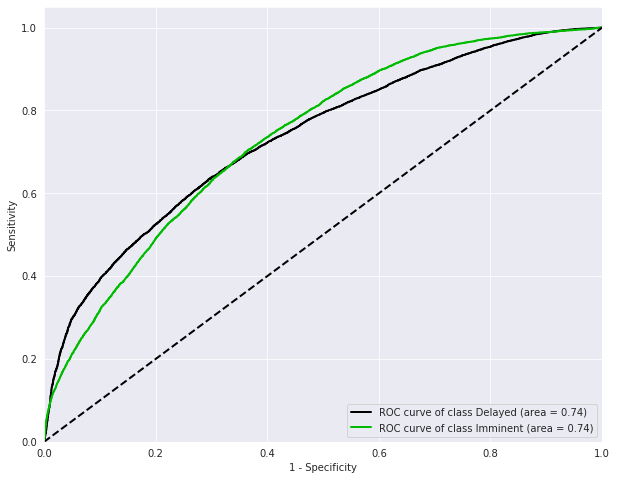

In [45]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc(label_test, prob, title='', ax=ax, plot_micro=False, plot_macro=False)
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')

In [51]:
threshold = 0.38
pred = (pos_prob > threshold).astype(np.int64)
cm = confusion_matrix(y_test_cross_mimic, pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test_cross_mimic, pos_prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'threshold': threshold,
}
metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.730
specificity,0.606
ppv,0.382
npv,0.871
f1,0.502
auroc,0.735
threshold,0.380


### Metrics

In [6]:
with open(args.workdir/args.model/f'mlh_mimic_preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  probs = pickle.load(f)
  preds = pickle.load(f)

bam = BinaryAvgMetrics(targs, preds, [prob[:, 1] for prob in probs])
bam.get_avg_metrics(defn=True)

,Value,Definition
sensitivity,0.723,"When it's ACTUALLY YES, how often does it PREDICT YES?"
specificity,0.602,"When it's ACTUALLY NO, how often does it PREDICT NO?"
ppv,0.374,"When it PREDICTS YES, how often is it correct?"
auroc,0.734,Indicates how well the model is capable of distinguishing between classes
npv,0.868,"When it PREDICTS NO, how often is it correct?"
f1,0.493,Harmonic mean of sensitivity and ppv


In [7]:
bam.get_avg_metrics(conf=0.95)

,Mean,Lower,Upper
sensitivity,0.723,0.715,0.730
specificity,0.602,0.463,0.741
ppv,0.374,0.296,0.452
auroc,0.734,0.682,0.787
npv,0.868,0.835,0.901
f1,0.493,0.424,0.562


## Metrics

In [ ]:
with open(args.workdir/f'preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  probs = pickle.load(f)
  preds = pickle.load(f)

bam = BinaryAvgMetrics(targs, preds, [prob[:, 1] for prob in probs])
bam.get_avg_metrics(defn=True)

In [ ]:
bam.get_avg_metrics(conf=0.95)

In [ ]:
fig, ax = plt.subplots(figsize=(11, 8))
plot_cm(ax, bam.cm_avg, ['Delayed', 'Imminent'])

if save:
  fig.savefig(args.figdir/f'mean_cm.pdf', dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_mean_roc(ax, bam.targs, probs)

if save:
  fig.savefig(args.figdir/f'mean_roc.pdf', dpi=300)